In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt

## 加载声音文件

Shape of waveform: torch.Size([2, 138097])
Sample rate of waveformL 44100


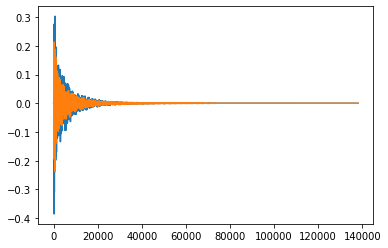

In [2]:
filename = "./audio_file/二通01.wav"
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveformL {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())

## 转变数据

torchaudio支持不断增长的转换列表。
- 重采样：将波形重采样为其他采样率。
- 频谱图：从波形创建频谱图。
- GriffinLim ：使用 Griffin-Lim 转换从线性比例幅度谱图计算波形。
- ComputeDeltas ：计算张量(通常是声谱图）的增量系数。
- ComplexNorm ：计算复数张量的范数。
- MelScale ：使用转换矩阵将正常 STFT 转换为 Mel 频率 STFT。
- AmplitudeToDB ：这将频谱图从功率/振幅标度变为分贝标度。
- MFCC ：根据波形创建梅尔频率倒谱系数。
- MelSpectrogram ：使用 PyTorch 中的 STFT 功能从波形创建 MEL 频谱图。
- MuLawEncoding ：基于 mu-law 压扩对波形进行编码。
- MuLawDecoding ：解码 mu-law 编码波形。
- TimeStretch ：在不更改给定速率的音高的情况下，及时拉伸频谱图。
- FrequencyMasking ：在频域中对频谱图应用屏蔽。
- TimeMasking ：在时域中对频谱图应用屏蔽。

Shape of spectrogram:torch.Size([2, 201, 691])


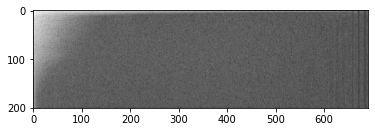

In [3]:
specgram = torchaudio.transforms.Spectrogram()(waveform)

print("Shape of spectrogram:{}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')

Shape of spectrogram: torch.Size([2, 128, 691])


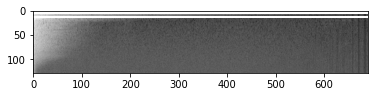

In [4]:
specgram = torchaudio.transforms.MelSpectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy(), cmap='gray')

Shape of transformed waveform:torch.Size([1, 13810])


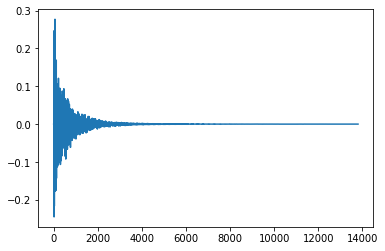

In [5]:
new_sample_rate = sample_rate/10

channel = 0
transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel].view(1,-1))

print("Shape of transformed waveform:{}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())

In [6]:
# Let's check if the tensor is in the interval [-1,1]
print("Min of waveform: {}\nMax of waveform: {}\nMean of waveform: {}".format(waveform.min(), waveform.max(), waveform.mean()))

Min of waveform: -0.385284423828125
Max of waveform: 0.302947998046875
Mean of waveform: 3.328388856971287e-06


In [7]:
def normalize(tensor):
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

# waveform = normalize(waveform)

Shape of transformed waveform:torch.Size([2, 138097])


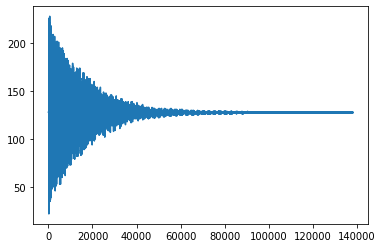

In [8]:
transformed = torchaudio.transforms.MuLawEncoding()(waveform)

print("Shape of transformed waveform:{}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())

Shape of recovered waveform:torch.Size([2, 138097])


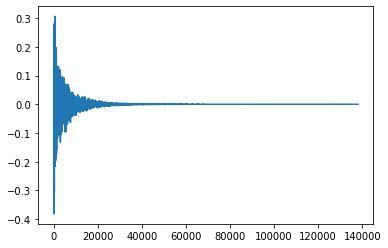

In [9]:
reconstructed = torchaudio.transforms.MuLawDecoding()(transformed)

print("Shape of recovered waveform:{}".format(reconstructed.size()))

plt.figure()
plt.plot(reconstructed[0,:].numpy())

In [10]:
# Compute median relative difference
err = ((waveform-reconstructed).abs() / waveform.abs()).median()

print("Median relative difference between original and MuLaw reconstucted signals: {:.2%}".format(err))

Median relative difference between original and MuLaw reconstucted signals: 29.37%


## 功能性
上面看到的转换依赖于较低级别的无状态函数进行计算。 这些功能在torchaudio.functional下可用。 完整列表位于此处为，包括：
- istft ：短时傅立叶逆变换。
- 增益：对整个波形进行放大或衰减。
- 抖动：增加以特定位深度存储的音频的动态范围。
- compute_deltas ：计算张量的增量系数。
- equalizer_biquad ：设计双二阶峰均化器滤波器并执行滤波。
- lowpass_biquad ：设计双二阶低通滤波器并执行滤波。
- highpass_biquad ：设计双二阶高通滤波器并执行滤波。

Shape of transformed waveform:torch.Size([2, 138097])


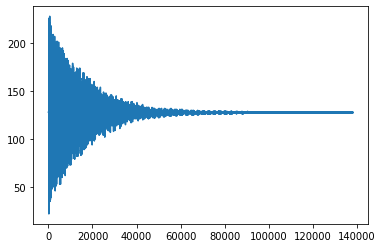

In [11]:
mu_law_encoding_waveform = torchaudio.functional.mu_law_encoding(waveform, quantization_channels=256)

print("Shape of transformed waveform:{}".format(mu_law_encoding_waveform.size()))

plt.figure()
plt.plot(mu_law_encoding_waveform[0,:].numpy())

Shape of computed deltas: torch.Size([2, 128, 691])


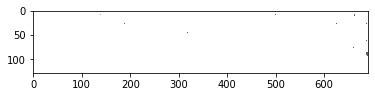

In [12]:
computed = torchaudio.functional.compute_deltas(specgram, win_length=3)
print("Shape of computed deltas: {}".format(computed.shape))

plt.figure()
plt.imshow(computed.log2()[0,:,:].detach().numpy(), cmap='gray')

In [13]:
gain_waveform = torchaudio.functional.gain(waveform, gain_db=5.0)
print("Min of gain_waveform: {}\nMax of gain_waveform: {}\nMean of gain_waveform: {}".format(gain_waveform.min(), gain_waveform.max(), gain_waveform.mean()))

dither_waveform = torchaudio.functional.dither(waveform)
print("Min of dither_waveform: {}\nMax of dither_waveform: {}\nMean of dither_waveform: {}".format(dither_waveform.min(), dither_waveform.max(), dither_waveform.mean()))

Min of gain_waveform: -0.6851433515548706
Max of gain_waveform: 0.5387262105941772
Mean of gain_waveform: 5.9187973420193885e-06
Min of dither_waveform: -0.38525390625
Max of dither_waveform: 0.30291748046875
Mean of dither_waveform: 1.8590271793073043e-05


Min of lowpass_waveform: -0.33250075578689575
Max of lowpass_waveform: 0.28127869963645935
Mean of lowpass_waveform: 3.3283806715189712e-06


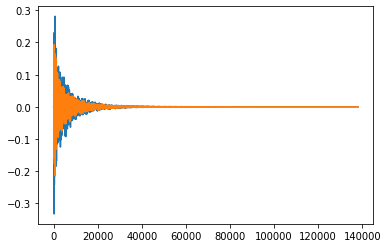

In [14]:
lowpass_waveform = torchaudio.functional.lowpass_biquad(waveform, sample_rate, cutoff_freq=3000)

print("Min of lowpass_waveform: {}\nMax of lowpass_waveform: {}\nMean of lowpass_waveform: {}".format(lowpass_waveform.min(), lowpass_waveform.max(), lowpass_waveform.mean()))

plt.figure()
plt.plot(lowpass_waveform.t().numpy())

Min of highpass_waveform: -0.30058568716049194
Max of highpass_waveform: 0.3068636953830719
Mean of highpass_waveform: 5.19488063677187e-11


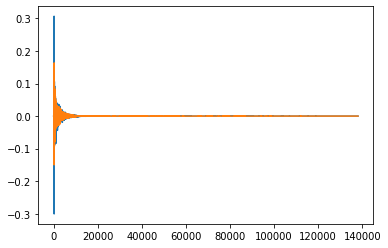

In [15]:
highpass_waveform = torchaudio.functional.highpass_biquad(waveform, sample_rate, cutoff_freq=2000)

print("Min of highpass_waveform: {}\nMax of highpass_waveform: {}\nMean of highpass_waveform: {}".format(highpass_waveform.min(), highpass_waveform.max(), highpass_waveform.mean()))

plt.figure()
plt.plot(highpass_waveform.t().numpy())

Shape of spectrogram:torch.Size([689, 201])


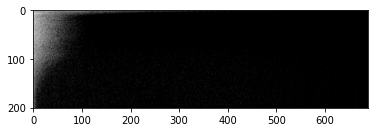

In [18]:
n_fft = 400.0
frame_length = n_fft / sample_rate * 1000.0
frame_shift = frame_length / 2.0

params = {
    'channel':0,
    'dither':0.0,
    'window_type':'hanning',
    'frame_length':frame_length,
    'frame_shift':frame_shift,
    'remove_dc_offset':False,
    'round_to_power_of_two':False,
    'sample_frequency':sample_rate,
    
}

specgram = torchaudio.compliance.kaldi.spectrogram(waveform, **params)

print("Shape of spectrogram:{}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.t().numpy(), cmap='gray')

Shape of fbank: torch.Size([689, 23])


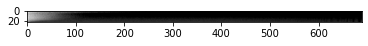

In [19]:
fbank = torchaudio.compliance.kaldi.fbank(waveform, **params)

print("Shape of fbank: {}".format(fbank.size()))

plt.figure()
plt.imshow(fbank.t().numpy(), cmap='gray')

Shape of mfcc: torch.Size([689, 13])


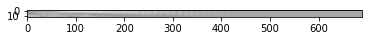

In [20]:
mfcc = torchaudio.compliance.kaldi.mfcc(waveform, **params)

print("Shape of mfcc: {}".format(mfcc.size()))

plt.figure()
plt.imshow(mfcc.t().numpy(), cmap='gray')


Waveform: tensor([[ 1.8311e-04,  6.1035e-05, -3.3569e-04,  ...,  3.3569e-04,
          5.1880e-04,  2.7161e-03]])
Sample rate: 8000
Labels: [1, 0, 1, 1, 1, 0, 1, 0]


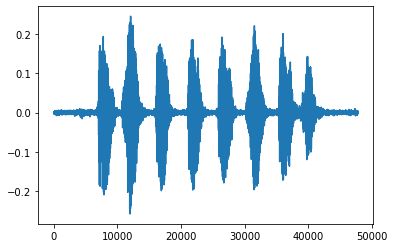

In [21]:
yesno_data = torchaudio.datasets.YESNO('./', download=True)

# A data point in Yesno is a tuple (waveform, sample_rate, labels) where labels is a list of integers with 1 for yes and 0 for no.

# Pick data point number 3 to see an example of the the yesno_data:
n = 3
waveform, sample_rate, labels = yesno_data[n]

print("Waveform: {}\nSample rate: {}\nLabels: {}".format(waveform, sample_rate, labels))

plt.figure()
plt.plot(waveform.t().numpy())